In [44]:
import pandas as pd
import numpy as np
import scipy.stats

import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import seaborn as sns
from mpl_toolkits.mplot3d import axes3d, Axes3D
%matplotlib notebook

from ipywidgets import interactive
import ipywidgets as widgets

# Introduction to Linear Regression

This is to follow the book: http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf

* Is there a relationship between advertising budget and sales?
* How strong is the relationship between advertising budget and sales?
* Which media contribute to sales?
* How accurately can we estimate the effect of each medium on sales?
* How accurately can we predict future sales?
* Is the relationship linear?
* Is there synergy among the advertising media?

$y \approx \beta_0+\beta_1*X$

$\hat{y} = \hat{\beta}_0+\hat{\beta}_1*X$

In [45]:
df = pd.read_csv('./data/Advertising.csv')
df.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


## Estimating the coefficients

Mean Squared Error approach -- minimize the average squared difference between a point and linear regression.

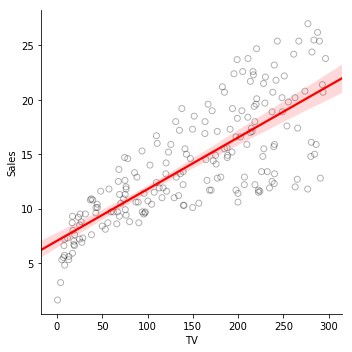

In [46]:
%matplotlib inline
sns.lmplot(x = 'TV', y = 'Sales'
           , data = df
           ,scatter_kws = {'color':'black', 'alpha':0.3, 'facecolors':'none','edgecolors':'black'}
           ,line_kws = {'color':'red'})

Experiment with the coefficients below to minimize RSS:

In [47]:
X = df['TV']
y = df['Sales']

In [48]:
def linear_fit(b0,b1):
    y_hat = b0+b1*X
    RSS = np.sum((y_hat-y)**2)
    
    fig = plt.figure(figsize = (10,5))
    ax = fig.add_subplot(1,2,1)
    ax.plot(X, y_hat, label = '$\hat{y}$', color = 'b')
    ax.scatter(X, y, label = 'Sales')
    ax.set_xlabel('TV')
    ax.set_ylabel('Sales')
    ax.set_title('RSS = %.2f'%RSS)
    ax.legend()
    
    ax = fig.add_subplot(1,2,2)
    sns.distplot(y_hat-y, ax = ax)
    ax.set_title('Error Distribution')
    ax.set_xlabel('$\hat{y}-y$')
    plt.show()
    
i_plot = interactive(linear_fit, b1 = (0.0,0.1,0.005), b0 = (0.0,10.0))
i_plot

interactive(children=(FloatSlider(value=5.0, description='b0', max=10.0), FloatSlider(value=0.05, description=…

According to the least squares approach, the equations for $\hat{\beta}_1$ and $\hat{\beta}_0$ are: 

$\hat{\beta}_1 = \frac{\sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})}{\sum_{i=1}^{n}(x_i-\bar{x})^2}$

$\hat{\beta}_0 = \bar{y}-\hat{\beta}_1\bar{x}$

In [49]:
def least_squares_estimate(X,y):
    b1_hat = np.sum((X-np.mean(X))*(y-np.mean(y)))/np.sum((X-np.mean(X))**2)
    b0_hat = np.mean(y)-b1_hat*np.mean(X)
    return b0_hat, b1_hat

least_squares_estimate(X,y)

(7.0325935491276965, 0.047536640433019736)

## Assessing the Accuracy of the Coefficients

The assumption is that the *true* relationship between X and y takes the form $y = f(X)+\epsilon$, where $\epsilon$ is a mean-zero random error term:

$y = \beta_0+\beta_1X+\epsilon$

Let us illustrate this with simulated data:

In [50]:
X = np.arange(-2,2,0.05)
y = 2 + 3*X + np.random.normal(0,5,X.shape)

b0_hat, b1_hat = least_squares_estimate(X,y)

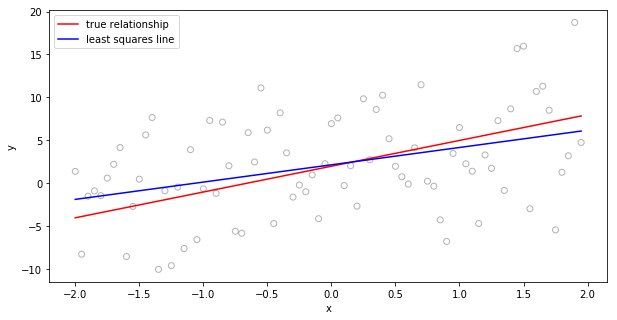

In [51]:
%matplotlib inline
plt.figure(figsize = (10,5))
plt.scatter(X,y,facecolors='none', edgecolors='black', 
            color = 'black', alpha = 0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(X,2+3*X, color = 'red', label = 'true relationship')
plt.plot(X,b0_hat+b1_hat*X, color = 'blue', label = 'least squares line')
plt.legend()
plt.show()

At this time, let us compute $\beta_0$ and $\beta_1$ based on sample of data:

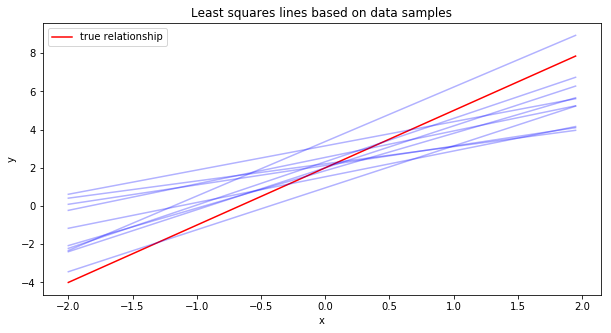

In [52]:
betas = []
num_tries = 10 # number of estimates
for _ in range(num_tries):
    indices = np.random.choice(X.shape[0]
                               ,size = round(0.4*X.shape[0]) # 0.4 -- sample size, 40% of the data
                               ,replace = False )
    betas.append(least_squares_estimate(X[indices],y[indices]))

plt.figure(figsize = (10,5))
plt.xlabel('x')
plt.ylabel('y')
plt.plot(X,2+3*X, color = 'red', label = 'true relationship')
for (b0_hat,b1_hat) in betas:
    plt.plot(X,b0_hat+b1_hat*X, color = 'blue', alpha = 0.3)
plt.title('Least squares lines based on data samples')
plt.legend()
plt.show()

The standard errors of $\beta_0$ and $\beta_1$ are as follows:

$SE(\hat{\beta}_0)^2 = \sigma^2\left[1/n+\frac{\bar{x}^2}{\sum_{i=1}^n\left(x_i-\bar{x}\right)^2}\right]$

$SE(\hat{\beta}_1)^2 = \frac{\sigma^2}{\sum_{i=1}^n\left(x_i-\bar{x}\right)^2}$

where $\sigma^2 = Var(\epsilon)$ that can be estimated as residual standard error (RSE):

$\sigma = RSE = \sqrt{RSS/(n-2)}$

95% confidence intervals are:
$\left[\hat{\beta}_0-2*SE(\hat{\beta}_0),\hat{\beta}_0+2*SE(\hat{\beta}_0)\right]$

$\left[\hat{\beta}_1-2*SE(\hat{\beta}_1),\hat{\beta}_1+2*SE(\hat{\beta}_1)\right]$

In [53]:
def standard_errors(betas,X,y):
    b0_hat, b1_hat = betas[0], betas[1]
    y_hat = b0_hat+b1_hat*X
    RSS = np.sum((y_hat-y)**2)
    var_e = RSE_squared = (RSS/(X.shape[0]-2))
    SE_b0 = (var_e*(1/X.shape[0]+np.mean(X)**2/np.sum((X-np.mean(X))**2)))**0.5
    SE_b1 = (var_e/np.sum((X-np.mean(X))**2))**0.5
    return SE_b0, SE_b1

betas = least_squares_estimate(X,y)
SE = standard_errors(betas,X,y)
print(SE)
print("Beta 95% confidence intervals: ")
print("\tBeta 0: [%.3f,%.3f]"%(betas[0]-2*SE[0],betas[0]+2*SE[0]))
print("\tBeta 1: [%.3f,%.3f]"%(betas[1]-2*SE[1],betas[1]+2*SE[1]))

(0.6207559400201667, 0.5375064347874504)
Beta 95% confidence intervals: 
	Beta 0: [0.926,3.409]
	Beta 1: [0.938,3.088]


Let us get back to our original dataset (Advertising):

In [54]:
X = df['TV']
y = df['Sales']
betas = least_squares_estimate(X,y)

print(betas)

SE = standard_errors(betas,X,y)
print(SE)

print("Beta 95% confidence intervals: ")
print("\tBeta 0: [%.3f,%.3f]"%(betas[0]-2*SE[0],betas[0]+2*SE[0]))
print("\tBeta 1: [%.3f,%.3f]"%(betas[1]-2*SE[1],betas[1]+2*SE[1]))

(7.0325935491276965, 0.047536640433019736)
(0.4578429402734785, 0.0026906071877968707)
Beta 95% confidence intervals: 
	Beta 0: [6.117,7.948]
	Beta 1: [0.042,0.053]


In summary, in the absence of TV advertising, on average, the sales will be between 6,117 and 7,948 units. Every 1,000 increase in TV advertising will result in increase in sales of between 42 and 53 units. 

### Hypothesis tests on the coefficients

H0: There is no relationship between X and y
Ha: There is some relationship between X and y

H0: $\beta_1 = 0$
Ha: $\beta_1 0$

t-statistics:

$t = \frac{\hat{\beta}_1}{SE(\hat{\beta}_1}$

In [55]:
betas, SE

((7.0325935491276965, 0.047536640433019736),
 (0.4578429402734785, 0.0026906071877968707))

In [56]:
t_stat = tuple([betas[i]/SE[i] for i in range(len(betas))])
t_stat

(15.360275174117552, 17.66762560087554)

Probability of getting these values randomly:

In [57]:
p_values = tuple([(1-scipy.stats.norm(0,1).cdf(np.abs(t)))*2 for t in t_stat])
p_values

(0.0, 0.0)

Let us make a function to compute simple linear regression statistics:

In [58]:
def simple_regression_stats(X,y):
    betas = least_squares_estimate(X,y)
    SE = standard_errors(betas,X,y)
    t_stat = tuple([betas[i]/SE[i] for i in range(len(betas))])
    p_values = tuple([(1-scipy.stats.norm(0,1).cdf(np.abs(t)))*2 for t in t_stat])
    return dict({'coefficients':betas
                ,'std. errors':SE
                ,'t-statistic':t_stat
                ,'p-values':p_values})
simple_regression_stats(X,y)

{'coefficients': (7.0325935491276965, 0.047536640433019736),
 'std. errors': (0.4578429402734785, 0.0026906071877968707),
 't-statistic': (15.360275174117552, 17.66762560087554),
 'p-values': (0.0, 0.0)}

We conclude that neither slope nor intercept are zeros, i.e. *reject the null hypothesis*:

 || Coefficient | Std. Error | t-statistic | p-value |
 |-|-------------|------------|-------------|-------- |
 |Intercept|7.0326|0.4578|15.3603|<0.0001|
 |Slope|0.0475|0.0027|17.6676|<0.0001|

## Assessing the Accuracy of the Model

Once we have rejected the null hypothesis, we need to estimate how accurate the model is

### Residual Standard Error

$RSE = \sqrt{\frac{RSS}{n-2}}$

$RSS = \sum_{i=1}^n\left(y_i-\hat{y}_i\right)^2$

In [59]:
betas = least_squares_estimate(X,y)
b0_hat, b1_hat = betas[0], betas[1]
y_hat = b0_hat+b1_hat*X
RSS = np.sum((y-y_hat)**2)
RSE = np.sqrt(RSS/(X.shape[0]-2))
print("RSE: %.2f"%RSE)

RSE: 3.26


RSE is considered the *lack of fit* to the data

### $R^2$ Statistic

RSE provides the goodness of fit in the *units* of data and so it is not always clear what constitutes a good model. $R^2$ is a proportion of variance in the data explained by the model.

$R^2 = \frac{TSS-RSS}{TSS} = 1 - \frac{RSS}{TSS}$, where $TSS = \sum_{i=1}^{n}\left(y_i-\bar{y}\right)^2$

In [60]:
TSS = np.sum((y-np.mean(y))**2)
R2 = 1 - RSS/TSS
print("R^2: %.2f"%R2)

R^2: 0.61


In fact, in case of a univariate linear regression $\sqrt{R^2}$ equals to the correlation coefficient between X and y:

In [61]:
np.corrcoef(X,y)[0][1], np.sqrt(R2)

(0.7822244248616064, 0.7822244248616065)

# Multiple Linear Regression

In case of multiple inputs (TV, Radio, and Newspaper), there are two problems:

1. It is unclear how to make a single prediction, from multiple regressions
2. The model does not consider cross input effects

Below are three single regressions:

In [62]:
simple_regression_stats(df['TV'],df['Sales'])

{'coefficients': (7.0325935491276965, 0.047536640433019736),
 'std. errors': (0.4578429402734785, 0.0026906071877968707),
 't-statistic': (15.360275174117552, 17.66762560087554),
 'p-values': (0.0, 0.0)}

In [63]:
simple_regression_stats(df['Radio'],df['Sales'])

{'coefficients': (9.311638095158283, 0.2024957833924397),
 'std. errors': (0.5629004962718711, 0.020411306360090635),
 't-statistic': (16.542245311258217, 9.92076547282496),
 'p-values': (0.0, 0.0)}

In [64]:
simple_regression_stats(df['Newspaper'],df['Sales'])

{'coefficients': (12.35140706927816, 0.054693098472273355),
 'std. errors': (0.6214201876094345, 0.016575721876358165),
 't-statistic': (19.876095620248947, 3.299590743633418),
 'p-values': (0.0, 0.0009682591818647168)}

Rather, the model should look like:

$y = \beta_0+\beta_1*X_1+\beta_2*X_2+\beta_3*X_3+\epsilon$

... and coefficient estimates:

$\hat{y} = \hat{\beta}_0+\hat{\beta}_1*X_1+\hat{\beta}_2*X_2+\hat{\beta}_3*X_3$

To compute $\hat{\beta}$, modify the data by adding column 0 for the intercept and apply linear algebra:

$\hat{\beta} = \left(X^TX\right)^{-1}X^Ty$

In [65]:
X = np.ones([df[['TV','Radio','Newspaper']].shape[0],3+1]) # add an extra column = 1 for the intercept
X[:,1:] = df[['TV','Radio','Newspaper']]
y = df['Sales']

In [66]:
XT = np.transpose(X)
XTX = np.dot(XT,X)
beta = np.dot(np.dot(np.linalg.inv(XTX),XT),y)
beta

array([ 2.93888937e+00,  4.57646455e-02,  1.88530017e-01, -1.03749304e-03])

Model output is now: $\hat{y} = X\cdot\beta$, and the residual standard error is computed as usual:

In [67]:
y_hat = np.dot(X, beta)
n,p = X.shape
RSS = np.sum((y-y_hat)**2)
RSE = np.sqrt(RSS/(n-p-1))
print("RSE: %.2f"%RSE)

RSE: 1.69


In [68]:
TSS = np.sum((y-np.mean(y))**2)
R2 = 1 - RSS/TSS
print("R^2: %.2f"%R2)

R^2: 0.90


To test the hypothesis whether any $\beta$ equals to 0, compute the standardized coefficient, $Z$ score:

$z_j = \frac{\hat{\beta}_j}{\hat{\sigma}\sqrt{v_j}}$

where

$v = diag\left(X^TX\right)^{-1}$, $\sigma^2 = \frac{1}{n-2-p}RSS$, $p = 3$ since we use three fields: TV, Radio, and Newspaper:

In [69]:
var_e = (1/(X.shape[0]-2-3))*RSS # sigma^2
var_e

2.855514168729165

In [70]:
v = np.diag(np.linalg.inv(XTX))
t_stat = beta/(np.sqrt(var_e)*np.sqrt(v))
t_stat

array([ 9.39822125, 32.72482193, 21.83757388, -0.17626321])

In [71]:
p_values = tuple([scipy.stats.chi2(X.shape[0]-2-3).cdf(np.abs(t)) for t in t_stat])
p_values

(3.3400026129809233e-90,
 2.2106893409231633e-42,
 3.5710060453492373e-57,
 1.3622297202036477e-256)

In [72]:
p_values = tuple([(1-scipy.stats.norm(0,1).cdf(np.abs(t)))*2 for t in t_stat])
p_values

(0.0, 0.0, 0.0, 0.8600871655476616)

Now we can put it into one function:

In [73]:
def multiple_regression_stats(X,y):
    n, p = X.shape
    _X = np.ones([n,p+1]) # add an extra column = 1 for the intercept
    _X[:,1:] = X[:]
    
    XT = np.transpose(_X)
    XTX = np.dot(XT,_X)
    invXTX = np.linalg.inv(XTX)
    beta = np.dot(np.dot(invXTX,XT),y)
    
    y_hat = np.dot(_X, beta)
    RSS = np.sum((y-y_hat)**2)
    RSE = np.sqrt(RSS/(n-p-1))
    
    TSS = np.sum((y-np.mean(y))**2)
    R2 = 1 - RSS/TSS
    
    var_e = (1/(X.shape[0]-2-p))*RSS # sigma^2
    v = np.diag(np.linalg.inv(XTX))
    t_stat = beta/(np.sqrt(var_e)*np.sqrt(v))
    p_values = tuple([(1-scipy.stats.norm(0,1).cdf(np.abs(t)))*2 for t in t_stat])
    
    return dict({
        'coefficients':beta
        ,'t-stats':t_stat
        ,'p_values':p_values
        ,'R^2':R2
        ,'TSS':TSS
        ,'RSS':RSS
        ,'RSE':RSE
        ,'y_hat':y_hat
    })

multiple_regression_stats(df[['TV','Radio','Newspaper']],df['Sales'])['R^2']

0.8972106381789522

In summary for multiple linear regression, we get:

| | Coefficient | t-statistic | p-value |
|-|-------------|-------------|-------- |
|Intercept|2.9389|9.3982|<0.0001|
|TV|0.0458|0.0027|<0.0001|
|Radio|0.1885|21.8376|<0.0001|
|Newspaper|-0.0010|-0.1762|0.86|
 
Based on the above, we reject the null hypothesis for $\beta_0$ Intercept $\beta_1$ TV, and $\beta_2$ Radio, but do not reject it for $\beta_3$ Newspaper. 

## Important Questions
1. Is at least one of the predictors $X_1$,$X_2$,...$X_p$ useful in predicting the response?
2. Do all the predictors help to explainY, or is only a subset of thepredictors useful?
3. How well does the model fit the data?
4. Given a set of predictor values, what response value should we predict,and how accurate is our prediction?

### Question 1

We need to test the null hypothesis:
$H_0$: all $\beta_i = 0$

vs. the alternative:
$H_a$: at least one  $\beta_i \neq 0$

Use F-statistic to reject the null hypothesis:

$F = \frac{(TSS-RSS)/p}{RSS/(n-p-1)}$

In [74]:
m = multiple_regression_stats(df[['TV','Radio','Newspaper']],df['Sales'])
n, p = df[['TV','Radio','Newspaper']].shape
F = ((m['TSS']-m['RSS'])/p)/(m['RSS']/(n-p-1))
print("F-statistic:%.2f"%F)

F-statistic:570.27


F is far larger than 1, so discard $H_0$

### Question 2

Which variables are important? There are three approaches:

* Forward selection -- start with an empty model, do $p$ simple linear regressions and add the variable that resulted in the lowest RSS. We then add a second variable that results in the lowest RSS among all $p-1$ two-variable linear regressions;
* Backward selection (cannot be used when p > n) -- start with a complete model and then remove the variable with the highest p-value; 
* Mixed selection -- start with forward selection, then if p-value for any variable rises above a threshold, remove the variable;

### Question 3

How good is the model fit? Use $R^2$ and RSE to estimate this. Let us consider several models:
1. TV only
2. TV and Radio
3. TV, Radio, and Newspaper

In [75]:
m1 = multiple_regression_stats(df[['TV']],df['Sales'])
print("TV only: RSE: %.4f, R^2: %.4f"%(m1['RSE'],m1['R^2']))

m2 = multiple_regression_stats(df[['TV','Radio']],df['Sales'])
print("TV and Radio: RSE: %.4f, R^2: %.4f"%(m2['RSE'],m2['R^2']))

m3 = multiple_regression_stats(df[['TV','Radio','Newspaper']],df['Sales'])
print("TV, Radio, Newspaper: RSE: %.4f, R^2: %.4f"%(m3['RSE'],m3['R^2']))


TV only: RSE: 3.2587, R^2: 0.6119
TV and Radio: RSE: 1.6814, R^2: 0.8972
TV, Radio, Newspaper: RSE: 1.6855, R^2: 0.8972


The increase in $R^2$ value is miniscule from model 2 to model 3. The RSE has grown due to adding an additional variable.

Let us also visualize model 2 to illustrate its performance:

In [76]:
df.describe()

,Unnamed: 0,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,147.042500,23.264000,30.554000,14.022500
std,57.879185,85.854236,14.846809,21.778621,5.217457
min,1.000000,0.700000,0.000000,0.300000,1.600000
25%,50.750000,74.375000,9.975000,12.750000,10.375000
50%,100.500000,149.750000,22.900000,25.750000,12.900000
75%,150.250000,218.825000,36.525000,45.100000,17.400000
max,200.000000,296.400000,49.600000,114.000000,27.000000


In [78]:
TV = np.arange(0,300,2)
Radio = np.arange(0,60,2)
TV, Radio = np.meshgrid(TV, Radio)
b0, b1, b2 = m2['coefficients']
y_hat_plane = b0+b1*TV+b2*Radio
#y_hat_plane

<IPython.core.display.Javascript object>


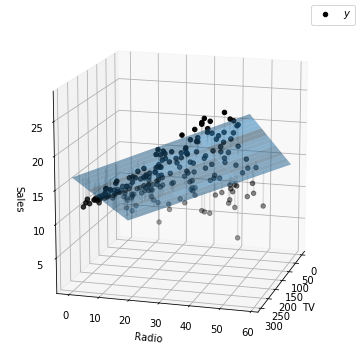

In [79]:
%matplotlib notebook
%matplotlib notebook

fig = plt.figure(figsize = (5,5))
ax = Axes3D(fig, azim = 0, elev = 0)
ax.plot_surface(TV, Radio, y_hat_plane
                ,rstride=10, cstride=10,shade=True,alpha = 0.5)
ax.scatter(df['TV'],df['Radio'],df['Sales']
           , label = '$y$', color = 'black'
          , marker = 'o')
          
for i in range(df.shape[0]):
    ax.plot((df.loc[i,'TV'],df.loc[i,'TV'])
            ,(df.loc[i,'Radio'],df.loc[i,'Radio'])
            ,(df.loc[i,'Sales'],m2['y_hat'][i])
           ,color = 'black',alpha=0.1)

ax.set_xlabel('TV')
ax.set_ylabel('Radio')
ax.set_zlabel('Sales')
ax.legend()
plt.show()


When both Radio and TV are high (or low), the model overestimates the values.

### Question 4: Predictions

There are two types of errors: reducible and irreducible. Reducible error pertains to estimating coefficients $\hat{\beta}_i$. Irreducible error is due to applicability of the model to the data, that is a linear regression might not fit the data no matter how close $\hat{\beta}_i$ to the true values of $\beta_i$.

Use confidence interval to estimate the accuracy of the predictions: For example, given that \\$100,000 is spent on TV advertising and \\$20,000 is spent on radio advertising in each city, the 95\% confidence interval is \[10,985,11,528\]

## Linear Regression on SKLearn

### LinearRegression from sklearn.linear_model
This is both simple and multiple linear regression

In [36]:
from sklearn.linear_model import LinearRegression

In [37]:
lr = LinearRegression()
lr.fit(df[['TV','Radio','Newspaper']],df['Sales'])
intercept, slope = lr.intercept_, lr.coef_
intercept, slope

(2.9388893694594085, array([ 0.04576465,  0.18853002, -0.00103749]))

### linregress from scipy.stats

In [38]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(df['TV'], df['Sales'])
slope, intercept, r_value, p_value, std_err

(0.047536640433019736,
 7.0325935491276965,
 0.7822244248616064,
 1.4673897001947178e-42,
 0.0026906071877968716)

# Lab

In this lab you build linear regression models to predict housing prices (original, listing, or selling) price based on house attributes like lot size, square footage, number of bedrooms/bathrooms, housing coordinates, and listing day of week/month.

Here is what needs to be done:
1. Identify your X and y;
2. Answer questions 1-3;
3. Document your findings;

In [90]:
df = pd.read_csv('./data/storm_lake_houses_coords.csv')

df = df[['LotSz','SqFt','Year','Bed','total_baths','full_baths','three_q_baths'
         ,'half_baths','q_baths'
         ,'DayofWkListed','MonthListed','lat','lon'
         ,'OrigPrice','ListPrice','SellingPrice']].dropna()
df.head()

,LotSz,SqFt,Year,Bed,total_baths,full_baths,three_q_baths,half_baths,q_baths,DayofWkListed,MonthListed,lat,lon,OrigPrice,ListPrice,SellingPrice
0,16405,4010,1991,5,4,4,0,0,0,4,1,42.635949,-95.190106,550000,299900,280000
1,14000,3412,1907,4,2,2,0,0,0,1,12,42.639569,-95.200812,162000,162000,156000
2,14000,1562,1981,3,3,3,0,0,0,5,11,42.632047,-95.242888,217000,217000,204000
3,13500,1872,1977,3,3,2,0,0,1,5,1,42.644993,-95.184715,174900,159500,150000
4,21702,2642,1953,3,2,1,1,0,0,3,2,42.646798,-95.217970,225000,225000,215000


### Method 1

Choose models with the lowest RSS/RSE

In [91]:
col_names = ['LotSz','SqFt','Year','Bed','total_baths','full_baths','three_q_baths'
         ,'half_baths','q_baths'
         ,'DayofWkListed','MonthListed','lat','lon']

for c in col_names:
    m = multiple_regression_stats(df[[c]],df['ListPrice'])
    print("Field %s : RSE: %.4f, R^2: %.4f"%(c,m['RSE'],m['R^2']))

Field LotSz : RSE: 34276.4815, R^2: 0.1072
Field SqFt : RSE: 34452.1093, R^2: 0.0980
Field Year : RSE: 36091.1422, R^2: 0.0102
Field Bed : RSE: 36008.1711, R^2: 0.0147
Field total_baths : RSE: 35670.5174, R^2: 0.0331
Field full_baths : RSE: 35591.9638, R^2: 0.0374
Field three_q_baths : RSE: 36224.7487, R^2: 0.0028
Field half_baths : RSE: 36211.5498, R^2: 0.0036
Field q_baths : RSE: 36200.8914, R^2: 0.0041
Field DayofWkListed : RSE: 36272.3769, R^2: 0.0002
Field MonthListed : RSE: 35915.6753, R^2: 0.0198
Field lat : RSE: 32868.2691, R^2: 0.1791
Field lon : RSE: 35491.4033, R^2: 0.0428


In [92]:
cols = ['LotSz','lat']
m = multiple_regression_stats(df[cols],df['ListPrice'])
print("Fields (%s) : RSE: %.4f, R^2: %.4f"%(','.join(cols),m['RSE'],m['R^2']))

Fields (LotSz,lat) : RSE: 32242.9604, R^2: 0.2150


In [93]:
cols = ['LotSz','lat','SqFt']
m = multiple_regression_stats(df[cols],df['ListPrice'])
print("Fields (%s) : RSE: %.4f, R^2: %.4f"%(','.join(cols),m['RSE'],m['R^2']))

Fields (LotSz,lat,SqFt) : RSE: 31259.2127, R^2: 0.2668


In [94]:
cols = ['LotSz','lat','SqFt','full_baths']
m = multiple_regression_stats(df[cols],df['ListPrice'])
print("Fields (%s) : RSE: %.4f, R^2: %.4f"%(','.join(cols),m['RSE'],m['R^2']))

Fields (LotSz,lat,SqFt,full_baths) : RSE: 31042.6435, R^2: 0.2815


In [95]:
cols = ['LotSz','lat','SqFt','full_baths','lon']
m = multiple_regression_stats(df[cols],df['ListPrice'])
print("Fields (%s) : RSE: %.4f, R^2: %.4f"%(','.join(cols),m['RSE'],m['R^2']))

Fields (LotSz,lat,SqFt,full_baths,lon) : RSE: 30735.4718, R^2: 0.3002


In [96]:
cols = ['LotSz','lat','SqFt','full_baths','lon','Year']
m = multiple_regression_stats(df[cols],df['ListPrice'])
print("Fields (%s) : RSE: %.4f, R^2: %.4f"%(','.join(cols),m['RSE'],m['R^2']))

Fields (LotSz,lat,SqFt,full_baths,lon,Year) : RSE: 28838.6046, R^2: 0.3879


In [97]:
list(zip(cols,m['p_values']))

[('LotSz', 3.785306879056094e-06),
 ('lat', 0.015759127328610623),
 ('SqFt', 1.1187101689458245e-08),
 ('full_baths', 3.333410942385484e-06),
 ('lon', 0.8739673513284056),
 ('Year', 0.012685846259721911)]

### Method 2 (Backward selection)

Start with all variables and remove those with the largest p-values

In [98]:
cols = [
'LotSz','SqFt','Year','Bed','total_baths','full_baths','three_q_baths'
         ,'half_baths','q_baths'
         ,'DayofWkListed','MonthListed','lat','lon']
m = multiple_regression_stats(df[cols],df['ListPrice'])
sorted(list(zip(cols,m['p_values'])), key = lambda x:-x[1])

[('full_baths', 0.9999233953683773),
 ('q_baths', 0.999923299200888),
 ('DayofWkListed', 0.9999232552467492),
 ('half_baths', 0.9999231967241666),
 ('three_q_baths', 0.9999231679701737),
 ('MonthListed', 0.92939681492033),
 ('lat', 0.9274867678042695),
 ('LotSz', 0.6023682637190935),
 ('lon', 0.5347762685625628),
 ('Year', 0.206837056389916),
 ('Bed', 0.0052627015421991),
 ('SqFt', 1.42090466059841e-08),
 ('total_baths', 4.1766037295332126e-09)]

In [99]:
cols = ['LotSz','SqFt','Year','Bed']
m = multiple_regression_stats(df[cols],df['ListPrice'])
sorted(list(zip(cols,m['p_values'])), key = lambda x:-x[1])

[('LotSz', 0.0022506461015101564),
 ('Bed', 0.0003620666566028774),
 ('SqFt', 0.0003142970069780482),
 ('Year', 5.158671956051464e-06)]

In [100]:
m['RSE'],m['R^2']

(31816.545937416286, 0.2452651425554364)